# Counterfactual Modeling with a Biochemical Network

This workflow demonstrates counterfactual modeling using a [dynamic model of biochemical signaling in lung cancer](https://wwwdev.ebi.ac.uk/biomodels/BIOMD0000000427).

## Model background

### What is this?


This is a dynamic model of cell signaling in lung cancer by [Bianconi et al 2012](https://wwwdev.ebi.ac.uk/biomodels/BIOMD0000000427). Visualization of the model: ![bianconi_viz](https://i.imgur.com/6KUXKsy.png)

The nodes 'sos', 'ras', 'pi3k', 'akt', 'raf', 'mek', 'erk', and 'p90' represent concentrations of enzymatically active proteins at steady state.  This dynamic model is specified as a set of species and reactions between species using Michaelis-Menton kinetics.  The model can be downloaded from [biomodels.org](https://wwwdev.ebi.ac.uk/biomodels/BIOMD0000000427) as a file written in a markup language called SBML, which can be compiled with various software tools.

A module in this repository called `cancer_signaling` uses structural causal modeling to represent the system at *steady state*.  This approach assumes the system is stochastic, and models the probability distribution of the concentrations of the proteins.  The derivations underlying the model can be found in the *bianconi_math* document.

### Counterfactual reasoning on a biochemical model can inform experimental design.

Suppose an experimentalist wanted to do an experiment on the system (eg. forcing a variable's value to increase or knocking it out).  Furthermore, suppose she already has data collected under entirely different conditions than in the proposed experiment.

Counterfactual reasoning could simulate from a probability distribution representing the outcome of the experiment prior to spending the resources on the experiment.  This could save resources by, for example, prioritizing experiments more likely to produce interesting discoveries.

### Who would use this?

This type of dynamic model simulates biochemical reactions in cells. They are used in fields such as drug discovery and synthetic biology to model the effects of an intervention in the cellular system (such as a candidate compound or manipulation of the genetic machinery).

In [1]:
from math import exp

from pprint import pprint
import pyro
from pyro.distributions import LogNormal
from pyro import condition, do, infer, sample
from pyro.infer import EmpiricalMarginal
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import NUTS
import torch
import warnings
warnings.filterwarnings('ignore')

from causal_demon.transmitters import cancer_signaling

from matplotlib import pyplot as plt
%matplotlib inline


### Helper functions for inference

Since the inference algorithm is not the focus of this tutorial, I hide the choice of algorithm in an abstraction.

In [2]:
def infer_mcmc(model):
    nuts_kernel = NUTS(model, adapt_step_size=True)
    return MCMC(nuts_kernel, num_samples=500, warmup_steps=300)

def infer_importance(model):
    return pyro.infer.Importance(model, num_samples=1000)

In [3]:
def plot_erk(data):
    plt.boxplot(data['erk'])
    plt.title("Empirical Distribution of Erk")
    plt.xlabel("Condition")
    plt.ylabel("Concentration")
    plt.show()

# Simulating "wild type" data from the model

"Wild type" refers to data forward-generated from the model. 

Pass in noise variables that capture the variation in the model.  Each noise term is modeled with a weakly informed prior.

In [4]:
noise_vars = ['N_egf', 'N_igf', 'N_sos', 'N_ras', 'N_pi3k', 'N_akt', 'N_raf', 'N_mek', 'N_erk']
# 4 observations
mean = torch.zeros(4)
noise_priors = {N: LogNormal(mean, 10) for N in noise_vars}

In [5]:
cancer_signaling(noise_priors)

{'egf': tensor([2.7954e+01, 4.8299e-05, 1.5163e+03, 9.9427e-03]),
 'igf': tensor([9.4691e-07, 3.3414e-01, 3.6192e-07, 4.3954e-01]),
 'sos': tensor([6.6813e+05, 9.2959e-03, 9.6350e-01, 1.4639e-02]),
 'ras': tensor([3.1628e+05, 3.5068e+08, 8.2278e-01, 1.3921e-02]),
 'pi3k': tensor([113766.5859, 120093.1250, 113535.1094,    619.6009]),
 'akt': tensor([397999.4688, 405185.7500, 397726.4688,   6370.0747]),
 'raf': tensor([7.7653e+03, 1.1844e+05, 2.1608e-02, 8.0440e+02]),
 'mek': tensor([1.8952e+05, 5.3718e+05, 1.7275e+00, 2.7386e+04]),
 'erk': tensor([5.1520e+05, 5.7953e+05, 1.4578e+08, 2.8049e+05])}

# Simulating an intervention experiment with the do-operator

Suppose we have an *intervention query*:

### Intervention Query: *What would happen if we blocked IGF and varied the amount of EGF?*

We could answer this query with an experiment:
* 3 conditions: EGF is varied from low (set to 800), medium (8000), to high (80000) concentrations
* 2 replicates of each condition.
* IGF is blocked (set to 0).

Prior to running the experiment, we can simulate the experiment using this model.  

**Why simulate experiments?**  Interventions with the `do` operator allow you to simulate the results of an experiment prior to spending the resources to conduct the experiment.

The interventions on IFG and EGF in this example are one set from a very large set of possible interventions.  Which sent of interventions is the best?  You can answer this by defining a cost function on the experimental results, applying that function to simulated data, and iteratively searching for a set of interventions that optimizes that cost function. 

In [6]:
mean = torch.zeros([3, 2])
noise_priors = {N: LogNormal(mean, .1) for N in noise_vars}
conditions = {
    'egf': torch.tensor(
        [
            [800., 800.],
            [8000., 8000.],
            [80000., 80000.]
        ]
    ),
    'igf': torch.zeros([3, 2])
}
initial_experiment = do(cancer_signaling, data=conditions)
initial_results = initial_experiment(noise_priors)
pprint(initial_results)

{'akt': tensor([[391321.7812, 391321.9688],
        [403665.8125, 403666.0000],
        [404943.1250, 404943.2812]]),
 'egf': tensor([[  800.,   800.],
        [ 8000.,  8000.],
        [80000., 80000.]]),
 'erk': tensor([[ 696.6604,  773.3032],
        [ 715.8817,  864.9516],
        [1529.1610, 1453.6689]]),
 'igf': tensor([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 'mek': tensor([[36.2059, 40.2062],
        [37.2172, 44.9751],
        [79.6481, 75.7078]]),
 'pi3k': tensor([[108277.4531, 108277.5469],
        [118715.4531, 118715.6094],
        [119870.9766, 119871.1562]]),
 'raf': tensor([[0.9847, 1.0942],
        [1.0185, 1.2332],
        [2.2002, 2.0968]]),
 'ras': tensor([[ 2.3053,  2.2083],
        [ 6.3968,  6.3944],
        [45.1486, 45.3369]]),
 'sos': tensor([[ 1.5161,  1.4281],
        [ 6.1106,  6.0218],
        [51.8502, 51.8491]])}


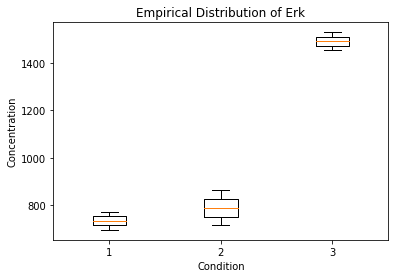

In [7]:
plot_erk(initial_results)

# Simulating a follow-up experiment using counterfactual inference

Suppose that after that initial experiment, we want to try a new experiment under a different set of conditions.  We could repeat the simulation we just ran under the new conditions, but we can improve the quality of the simulation by using the old data.

However, the old data was collected under different experimental conditions than in the proposed experiment.  This is addressed by posing a counterfactual query to the model:  

### Counterfactual Query: *Given the observations of Erk after fixing IGF to 0, what would Erk have been if IGF were set to 800?*

The following illustrates how to use the counterfactual simulation algorithm to answer this query.

### Conditioning on previous observations

Firstly, we pretend the simulated data from the previous section is real, and that we only collected data for Erk.

In [8]:
erk_data = initial_results['erk']


## Step 1: Condition the model of the initial experiment on the observed data

In [9]:
evidence = {'erk': initial_results['erk']}
initial_experiment_conditioned = condition(initial_experiment, data=evidence)

## Step 2: Update the noise priors given the observed data.

In [10]:
model_posterior = infer_importance(initial_experiment_conditioned).run(noise_priors)
noise_posteriors = {
    n: EmpiricalMarginal(model_posterior, sites=n)
    for n in noise_vars
}

## Step 3. Apply do-operator to original model to obtain a model of the new experiment

In [11]:
conditions = {
    'egf': torch.tensor(
        [
            [800., 800.],
            [8000., 8000.],
            [80000., 80000.],
        ]
    ),
    'igf': torch.tensor(
        [
            [800., 800.],
            [800., 800.],
            [800., 800.],
        ]
    ),
}
counterfactual_experiment = do(cancer_signaling, data=conditions)

### 4. Pass the updated noise marginals to the model of the new experiment.

In [12]:
new_results = counterfactual_experiment(noise_posteriors)

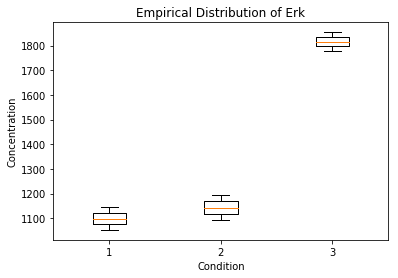

In [13]:
plot_erk(new_results)

## Extentions

* ~~Condition on IID data~~
* Use SVI
* Extend the model to accomadate uncertainty in parameters